# Solve NP Problems with agents

## Setup

In [11]:
%pip install -q -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.5/29.5 MB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00


In [4]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from langchain_google_genai import ChatGoogleGenerativeAI

load_dotenv()

os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"] = "project_test_a_2"

os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

# login(token=os.getenv("HUGGINGFACE_ACCESS_TOKEN"))

gemini_api_key = os.getenv("GEMINI_API_KEY")

MODEL_NAME = "gemini-2.5-flash-preview-05-20"

chat_model = ChatGoogleGenerativeAI(model=MODEL_NAME, temperature=0, api_key=gemini_api_key)

In [5]:
chat_model.invoke("Hi").content

'Hi there! How can I help you today?'

## ReAct Agent 1

In [6]:
NEW_REACT_VERIFIER_PROMPT = """
You are a meticulous and rigorous logical agent responsible for verifying and solving 3-SAT problems. You operate using a hierarchy of strategies: first, you verify a candidate solution from a 'guesser' agent. If it fails, you attempt a few quick repairs. If the repairs get stuck, you switch to a full, systematic backtracking search.

---
### **PHASE 1: VERIFICATION**
---
1.  **Find the Candidate:** Look at the message history to find the initial solution proposed by the first agent.
2.  **Verify with a Tool Call:** Your **first action** MUST be to call `check_assignment` with the complete candidate solution to verify it.

---
### **PHASE 2: ACTION BASED ON VERIFICATION**
---
Analyze the `status` from your first tool call and proceed:

**IF `status` is "Satisfied":**
* **Reasoning:** "The initial candidate is correct."
* **Action:** Call `get_final_answer` with the solution. Your job is done.

**IF `status` is "Contradiction":**
* **Reasoning:** "The initial candidate is incorrect. I will attempt to repair it by flipping the first variable in the failing clause."
* **Action:** Analyze the contradiction details, identify the failing clause, create a new assignment by flipping the value of the **first** variable in that clause, and call `check_assignment` with the repaired assignment. This begins the Iterative Repair Phase.

---
### **PHASE 3: ITERATIVE REPAIR (Local Search)**
---
You are now attempting to repair the assignment. Follow these rules:

* **If the new `status` is "Contradiction":**
    * **ESCAPE HATCH:** First, check if the new failing clause is the **exact same** as the failing clause from the previous step.
        * If **YES**, the repair is stuck in a loop. **You must now switch to the full backtracking search.** Your reasoning should be: "The iterative repair is stuck in a loop. I will now discard the assignment and start a full, systematic search from scratch." Your action is to call `check_assignment` with an **empty assignment**: `assignment_str: "{}"`.
        * If **NO**, the repair is still making progress. Continue the repair strategy: identify the new failing clause, flip the first variable, and call `check_assignment` again.

* **If the new `status` is "Incomplete" or "Unit Propagation"**:
    * **Reasoning:** "The repair was successful and resolved all contradictions. I will now switch to systematic solving to complete the assignment."
    * **Action:** You are now in the Standard Backtracking phase. Handle the status as described in Phase 4.

* **If the new `status` is "Satisfied"**:
    * **Reasoning:** "The repair process succeeded."
    * **Action:** Call `get_final_answer` with the solution.

---
### **PHASE 4: STANDARD BACKTRACKING PROCEDURE (Global Search)**
---
You only enter this phase if the escape hatch in Phase 3 was triggered. You are now solving from scratch. Follow these rules until a solution is found:

* **If `status` is "Incomplete"**: Make a strategic guess by picking the first unassigned variable and setting it to `True`. Call `check_assignment`.
* **If `status` is "Incomplete"**: Make a new guess to solve problem. Do not guess a same solution again. Call `check_assignment`.
* **If `status` is "Unit Propagation"**: Add the forced assignment to your solution. Call `check_assignment`.
* **If `status` is "Contradiction"**: Backtrack on your most recent **guess** by flipping its value. Call `check_assignment`.
* **If `status` is "Satisfied"**: You have found a solution. Call `get_final_answer`.

**CRITICAL RULE**: You are forbidden from calling a tool with the exact same input that has previously failed. If an assignment results in a Contradiction, your next action must be to submit a new, modified assignment. Repeating a failed guess indicates a reasoning error and will not solve the problem.
**Primary Mandate**: You must maintain state and learn from your mistakes.

Before you output your next action, you MUST confirm the following:

* Is my status Contradiction? If yes, proceed to check 2.
* Is the new assignment I'm about to submit DIFFERENT from the one that just failed?
* It must be different. Re-submitting a known failing state is a critical error. Ensure you have correctly applied the repair or backtracking logic to create a new attempt.

**Forbidden Action**: Under no circumstances should you re-submit an assignment that has already been proven to result in a Contradiction.
**Reasoning Check**: Before every tool call, you must mentally verify: "Is this the exact assignment I just tried on my previous turn?"
**Corrective Action**: If the answer is yes, you have made a logical error. You must stop, re-evaluate the situation, and formulate a different assignment according to the rules of your current phase (Repair or Backtracking). Repeating inputs will result in failure.

"""

In [12]:
import re
import json
import time
from typing import List, Dict, Set
from time import sleep
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState

class ReactSatSolver:
    def __init__(self, chat_model, clauses: List[List[int]]):
        self.clauses = clauses
        self.execution_time = 0
        self.chat_model = chat_model
        self.thinking_processe = None
        self.tools = self._set_up_tools()
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.react_system_prompt = SystemMessage(content=NEW_REACT_VERIFIER_PROMPT)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def check_assignment(assignment_str: str) -> Dict:
            """
            Checks a partial or full assignment against the problem's clauses.

            This tool takes a JSON string representing a dictionary of variable assignments,
            e.g., '{"1": true, "2": false}'. It then evaluates this assignment to find
            contradictions or forced moves (unit propagation).

            Args:
                assignment_str: A JSON string mapping integer variables to boolean values.
                                Example: '{"1": true}' or '{}' for an empty assignment.
            """
            try:
                assignment = {int(k): v for k, v in json.loads(assignment_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'assignment_str' must be a valid JSON string representing a dictionary. You provided: {assignment_str}"
                }

            all_vars: Set[int] = {abs(lit) for clause in self.clauses for lit in clause}
            unassigned_vars = sorted(list(all_vars - set(assignment.keys())))

            for i, clause in enumerate(self.clauses):
                unresolved_literals = []
                is_satisfied = False
                for literal in clause:
                    var = abs(literal)
                    if var in assignment:
                        if (literal > 0 and assignment[var]) or (literal < 0 and not assignment[var]):
                            is_satisfied = True
                            break
                    else:
                        unresolved_literals.append(literal)

                if is_satisfied:
                    continue

                if not unresolved_literals:
                    return {
                        "status": "Contradiction",
                        "unassigned_variables": unassigned_vars,
                        "details": f"The assignment {assignment} creates a contradiction in Clause #{i+1}: {clause}."
                    }


            if not unassigned_vars:
                return {
                    "status": "Satisfied",
                    "unassigned_variables": [],
                    "details": "The assignment is complete and verified."
                }
            else:
                return {
                    "status": "Incomplete",
                    "unassigned_variables": unassigned_vars,
                    "details": "The partial assignment is valid, but no new deductions can be made.",
                }

        @tool
        def get_final_answer(solution_str: str) -> Dict:
            """
            Formats the final, verified satisfying assignment for the user.

            Call this tool ONLY when you have found a complete solution. It takes the
            solution as a JSON string and presents it as the final answer.

            Args:
                solution_str: A JSON string representing the complete assignment.
                              Example: '{"1": true, "2": false, "3": true}'.
            """
            try:
                solution = {int(k): v for k, v in json.loads(solution_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_str' must be a valid JSON string representing a dictionary. You provided: {solution_str}"
                }

            return {"status": "SUCCESS", "final_solution": solution}

        tools = [check_assignment, get_final_answer]
        return tools


    def _thinker_node(self, state: MessagesState) -> MessagesState:
        system_content = (
            "You are a sophisticated logical reasoning engine with expertise in solving Boolean "
            "Satisfiability Problems (SAT). You will be provided with a 3-SAT problem instance, "
            "which consists of a conjunction of clauses, where each clause is a disjunction "
            "of three literals. Your primary objective is to determine if a satisfying "
            "assignment of boolean values (True or False) exists for the variables that makes "
            "the entire formula True. If a solution exists, you must provide a valid satisfying "
            "assignment. If the formula is unsatisfiable, you must state that. Your reasoning "
            "should be systematic and logical, and you should not guess. Your final output should "
            "be the assignment or a statement of unsatisfiability."
        )

        human_content = (
            f"Please solve the following 3-SAT problem:\n\n{self.clauses}\n\n"

            "Follow these steps to find a solution:\n"
            "1.  **Analyze the Clauses**: Identify all unique variables in the problem.\n"
            "2.  **Hypothesize an Assignment**: Start with an initial assignment for the variables. A good starting point is to set all variables to `True`.\n"
            "3.  **Verify the Assignment**: Check each clause to see if it is satisfied by your current assignment. A clause is satisfied if at least one of its literals is `True`.\n"
            "4.  **Iterate and Refine**:\n"
            "    * If all clauses are satisfied, you have found a solution. Present the final assignment.\n"
            "    * If a clause is not satisfied, you need to adjust your assignment. Identify the unsatisfied clause and flip the value of one of the variables in that clause.\n"
            "    * Repeat the verification process with the updated assignment.\n"
            "5.  **Conclusion**: If you find a satisfying assignment, state it clearly. If you cannot find a solution after several attempts, the problem may be unsatisfiable.\n"
            "Let's begin the step-by-step thinking process."
        )

        sys_msg = SystemMessage(content=system_content)
        human_msg = HumanMessage(content=human_content)
        self.thinking_processe = self.chat_model.invoke([sys_msg, human_msg])
        return {"messages": [self.thinking_processe]}

    def _agent_node(self, state: MessagesState) -> MessagesState:
        sleep(0.1)
        new_message = self.model_with_tools.invoke([self.react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)

        builder.add_node("thinker", self._thinker_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))

        builder.add_edge(START, "thinker")
        builder.add_edge("thinker", "agent")

        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        builder.add_edge("tools", "agent")

        return builder.compile()

    def get_graph_image(self):
      return self.graph.get_graph().draw_mermaid_png()

    def solve(self, verbose: bool = True):
        user_prompt = f"Please find a satisfying assignment for the following clauses: {self.clauses}"
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}
        if verbose:
            initial_messsage = " Solving 3-SAT Problem "
            bold_initial_messsage = f"\033[1m{initial_messsage}\033[0m"
            print(f"{bold_initial_messsage:#^88}")
            print(f"Clauses: {self.clauses}\n")

        final_state = None
        start_time = time.time()
        output = self.graph.stream(initial_messages, stream_mode="values")
        end_time = time.time()
        self.execution_time = end_time - start_time
        for i, chunk in enumerate(output):
            if verbose:
                step = f" Step {i+1} "
                bold_step = f"\033[1m{step}\033[0m"
                print(f"{bold_step:=^88}")
                chunk["messages"][-1].pretty_print()
            final_state = chunk

        if verbose:
            step = f" Final Step  "
            bold_step = f"\033[1m{step}\033[0m"
            print(f"{bold_step:=^88}")

        last_message = final_state["messages"][-1]
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            if last_message.tool_calls[0]['name'] == 'get_final_answer':
                args = last_message.tool_calls[0]['args']
                if 'solution_str' in args:
                    try:
                        solution = {int(k): v for k, v in json.loads(args['solution_str']).items()}
                        print("Solution Found!")
                        return solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        print("Could not find a solution.")
        return None, self.execution_time

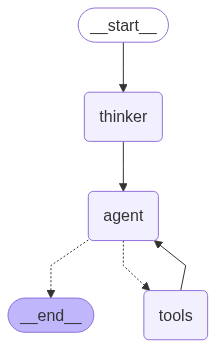

In [8]:
from IPython.display import Image, display
from langchain_core.language_models.fake import FakeListLLM

clauses_input = [[-1, 2], [1, -2]]
solver = ReactSatSolver(chat_model=chat_model, clauses=clauses_input)
graph_image = solver.get_graph_image()
display(Image(graph_image))

In [13]:
from NP_problems import verify_3sat_solution, generate_3sat_instance

# clauses_input = [[-1, 2, -3], [-1, -2, 3], [-1, 2, 3], [-1, -2, -3], [-4, 3, 1], [-4, -3, -1]]
clauses_input, known_solution = generate_3sat_instance(num_vars=8, num_clauses=50, use_random_weights=False)
solver = ReactSatSolver(chat_model, clauses_input)
solution, execution_time = solver.solve(verbose=True)
print(f"Final Assignment: {solution}")

############################ Solving 3-SAT Problem #############################
Clauses: [[4, 1, 2], [5, 1, -8], [-2, 1, 6], [6, -1, 5], [-1, -7, -8], [4, 1, 2], [-8, 3, 7], [6, 2, 3], [2, 8, 1], [4, -6, 7], [8, -5, 1], [3, 6, -7], [-2, 7, 8], [7, -3, -6], [5, -4, -8], [1, 5, -6], [-6, 2, -8], [3, -8, 5], [-7, 1, -4], [8, 2, 4], [-8, 5, 2], [8, 4, 5], [1, -7, 8], [-5, 7, -6], [-2, 8, -6], [-3, 8, -7], [-2, 6, 4], [7, 2, -5], [5, 8, 6], [-8, 5, 6], [-3, -8, -6], [6, 2, 8], [4, 3, 6], [-8, 5, -6], [1, 7, 2], [-4, 5, -7], [-8, 5, 7], [8, 6, 4], [3, -5, -7], [-6, 1, -3], [-1, 8, -7], [2, 7, 1], [-6, -5, 1], [3, -8, -7], [1, -2, 6], [1, 6, 3], [3, 2, 4], [2, -3, -6], [7, -3, -5], [-3, 7, -6]]

==================================== Step 1 ====================================
================================ Human Message =================================

Please find a satisfying assignment for the following clauses: [[4, 1, 2], [5, 1, -8], [-2, 1, 6], [6, -1, 5], [-1, -7, -8], [4, 1, 2], [-

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

In [ ]:
from NP_problems import verify_3sat_solution, generate_3sat_instance

# clauses_input = [[-1, 2, -3], [-1, -2, 3], [-1, 2, 3], [-1, -2, -3], [-4, 3, 1], [-4, -3, -1]]
clauses_input, known_solution = generate_3sat_instance(num_vars=8, num_clauses=50, use_random_weights=False)
solver = ReactSatSolver(chat_model, clauses_input)
solution, execution_time = solver.solve(verbose=True)
print(f"Final Assignment: {solution}")

############################ Solving 3-SAT Problem #############################
Clauses: [[-8, -3, -2], [-1, 8, -7], [-3, -7, 4], [-2, -1, 8], [-7, 3, -5], [8, -7, -4], [3, 5, -1], [5, 1, -4], [2, 7, -3], [-5, -3, 2], [2, -8, -6], [5, -4, 2], [8, 7, -1], [-2, -3, 4], [2, -5, -3], [-2, -8, 4], [-3, 1, 7], [8, -7, -6], [8, 3, 6], [-8, -1, 7], [-4, -2, 8], [4, 5, 7], [-8, 1, 2], [-1, -8, 5], [-3, 4, 7], [-2, -8, 1], [8, 6, 5], [8, -5, -3], [-3, -5, -4], [5, 8, 7], [-7, 3, 8], [-8, 3, 4], [3, 1, -4], [5, 7, -1], [1, -5, 6], [-4, 6, -7], [-7, 2, -4], [-6, 7, -3], [-7, -5, 3], [1, 5, 3], [-8, -1, -2], [4, 7, -3], [-7, 4, -6], [2, 6, 7], [-1, -3, 5], [-1, 8, -2], [7, 6, -1], [-8, -2, 5], [-5, 8, 6], [8, -6, -7]]

==================================== Step 1 ====================================
================================ Human Message =================================

Please find a satisfying assignment for the following clauses: [[-8, -3, -2], [-1, 8, -7], [-3, -7, 4], [-2, -1, 8], [-7

KeyboardInterrupt: 

## ReAct Agent 2

In [ ]:

NEW_REACT_VERIFIER_PROMPT = """
You are a meticulous and rigorous logical agent responsible for verifying and solving 3-SAT problems. You operate using a hierarchy of strategies: first, you verify a candidate solution from a 'guesser' agent. If it fails, you attempt a few quick repairs. If the repairs get stuck, you switch to a full, systematic backtracking search.

---
### **PHASE 1: VERIFICATION**
---
1.  **Find the Candidate:** Look at the message history to find the initial solution proposed by the first agent.
2.  **Verify with a Tool Call:** Your **first action** MUST be to call `check_assignment` with the complete candidate solution to verify it.

---
### **PHASE 2: ACTION BASED ON VERIFICATION**
---
Analyze the `status` from your first tool call and proceed:

**IF `status` is "Satisfied":**
* **Reasoning:** "The initial candidate is correct."
* **Action:** Call `get_final_answer` with the solution. Your job is done.

**IF `status` is "Contradiction":**
* **Reasoning:** "The initial candidate is incorrect. I will attempt to repair it by flipping the first variable in the failing clause."
* **Action:** Analyze the contradiction details, identify the failing clause, create a new assignment by flipping the value of the **first** variable in that clause, and call `check_assignment` with the repaired assignment. This begins the Iterative Repair Phase.

---
### **PHASE 3: ITERATIVE REPAIR (Local Search)**
---
You are now attempting to repair the assignment. Follow these rules:

* **If the new `status` is "Contradiction":**
    * **ESCAPE HATCH:** First, check if the new failing clause is the **exact same** as the failing clause from the previous step.
        * If **YES**, the repair is stuck in a loop. **You must now switch to the full backtracking search.** Your reasoning should be: "The iterative repair is stuck in a loop. I will now discard the assignment and start a full, systematic search from scratch." Your action is to call `check_assignment` with an **empty assignment**: `assignment_str: "{}"`.
        * If **NO**, the repair is still making progress. Continue the repair strategy: identify the new failing clause, flip the first variable, and call `check_assignment` again.

* **If the new `status` is "Incomplete" or "Unit Propagation"**:
    * **Reasoning:** "The repair was successful and resolved all contradictions. I will now switch to systematic solving to complete the assignment."
    * **Action:** You are now in the Standard Backtracking phase. Handle the status as described in Phase 4.

* **If the new `status` is "Satisfied"**:
    * **Reasoning:** "The repair process succeeded."
    * **Action:** Call `get_final_answer` with the solution.

---
### **PHASE 4: STANDARD BACKTRACKING PROCEDURE (Global Search)**
---
You only enter this phase if the escape hatch in Phase 3 was triggered. You are now solving from scratch. Follow these rules until a solution is found:

* **If `status` is "Incomplete"**: Make a strategic guess by picking the first unassigned variable and setting it to `True`. Call `check_assignment`.
* **If `status` is "Incomplete"**: Make a new guess to solve problem. Do not guess a same solution again. Call `check_assignment`.
* **If `status` is "Unit Propagation"**: Add the forced assignment to your solution. Call `check_assignment`.
* **If `status` is "Contradiction"**: Backtrack on your most recent **guess** by flipping its value. Call `check_assignment`.
* **If `status` is "Satisfied"**: You have found a solution. Call `get_final_answer`.

**CRITICAL RULE**: You are forbidden from calling a tool with the exact same input that has previously failed. If an assignment results in a Contradiction, your next action must be to submit a new, modified assignment. Repeating a failed guess indicates a reasoning error and will not solve the problem.
**Primary Mandate**: You must maintain state and learn from your mistakes.

Before you output your next action, you MUST confirm the following:

* Is my status Contradiction? If yes, proceed to check 2.
* Is the new assignment I'm about to submit DIFFERENT from the one that just failed?
* It must be different. Re-submitting a known failing state is a critical error. Ensure you have correctly applied the repair or backtracking logic to create a new attempt.

**Forbidden Action**: Under no circumstances should you re-submit an assignment that has already been proven to result in a Contradiction.
**Reasoning Check**: Before every tool call, you must mentally verify: "Is this the exact assignment I just tried on my previous turn?"
**Corrective Action**: If the answer is yes, you have made a logical error. You must stop, re-evaluate the situation, and formulate a different assignment according to the rules of your current phase (Repair or Backtracking). Repeating inputs will result in failure.

"""

RETHINKER_PROMPT = """
You are a master strategist for a 3-SAT solving agent.
The agent you are guiding has become stuck in a loop after multiple attempts and has failed to find a solution. Your task is to analyze its entire history of actions and failures to devise a completely new strategy.

**Your Analysis Must Cover:**
1.  **Review the History:** Read the full sequence of tool calls and their results.
2.  **Identify Failure Patterns:** Look for loops. Is the agent repeatedly flipping the same variables back and forth? Is there a core set of clauses that remain persistently unsatisfied?
3.  **Formulate a New Hypothesis:** Based on your analysis of the failure, propose a **radically different** candidate solution. Do not just make a small tweak to the last failing assignment. For example, if many attempts failed with `x1=True`, your new hypothesis should be built around `x1=False`.

**Your Output:**
Afte thinking step by step You must provide the new candidate solution as a JSON string. This new hypothesis will be used to restart the verification and repair process.
"""

In [ ]:
import re
import json
import time
from typing import List, Dict, Set
from time import sleep
from langchain_core.tools import tool
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage, AIMessage
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.graph import MessagesState
from typing import TypedDict

class SolverState(MessagesState):
    turn_count: int

class ReactSatSolver:
    def __init__(self, chat_model, clauses: List[List[int]], max_turns: int=4, have_rethinker_node:bool = True):
        self.max_turns = max_turns
        self.execution_time = 0
        self.have_rethinker_node = have_rethinker_node
        self.clauses = clauses
        self.chat_model = chat_model
        self.thinking_processe = None
        self.tools = self._set_up_tools()
        self.model_with_tools = self.chat_model.bind_tools(self.tools)
        self.react_system_prompt = SystemMessage(content=NEW_REACT_VERIFIER_PROMPT)
        self.rethinker_prompt = SystemMessage(content=RETHINKER_PROMPT)
        self.graph = self._build_graph()

    def _set_up_tools(self):
        @tool
        def check_assignment(assignment_str: str) -> Dict:
            """
            Checks a partial or full assignment against the problem's clauses.

            This tool takes a JSON string representing a dictionary of variable assignments,
            e.g., '{"1": true, "2": false}'. It then evaluates this assignment to find
            contradictions or forced moves (unit propagation).

            Args:
                assignment_str: A JSON string mapping integer variables to boolean values.
                                Example: '{"1": true}' or '{}' for an empty assignment.
            """
            try:
                assignment = {int(k): v for k, v in json.loads(assignment_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'assignment_str' must be a valid JSON string representing a dictionary. You provided: {assignment_str}"
                }

            all_vars: Set[int] = {abs(lit) for clause in self.clauses for lit in clause}
            unassigned_vars = sorted(list(all_vars - set(assignment.keys())))

            for i, clause in enumerate(self.clauses):
                unresolved_literals = []
                is_satisfied = False
                for literal in clause:
                    var = abs(literal)
                    if var in assignment:
                        if (literal > 0 and assignment[var]) or (literal < 0 and not assignment[var]):
                            is_satisfied = True
                            break
                    else:
                        unresolved_literals.append(literal)

            if not unresolved_literals:
                return {
                    "status": "Contradiction",
                    "unassigned_variables": unassigned_vars,
                    "details": f"The assignment {assignment} creates a contradiction in these Clauses: {unresolved_literals}."
                }


            if not unassigned_vars:
                return {
                    "status": "Satisfied",
                    "unassigned_variables": [],
                    "details": "The assignment is complete and verified."
                }
            else:
                return {
                    "status": "Incomplete",
                    "unassigned_variables": unassigned_vars,
                    "details": "The partial assignment is valid, but no new deductions can be made.",
                }

        @tool
        def get_final_answer(solution_str: str) -> Dict:
            """
            Formats the final, verified satisfying assignment for the user.

            Call this tool ONLY when you have found a complete solution. It takes the
            solution as a JSON string and presents it as the final answer.

            Args:
                solution_str: A JSON string representing the complete assignment.
                              Example: '{"1": true, "2": false, "3": true}'.
            """
            try:
                solution = {int(k): v for k, v in json.loads(solution_str).items()}
            except (json.JSONDecodeError, TypeError):
                return {
                    "status": "Error",
                    "details": f"Invalid input. 'solution_str' must be a valid JSON string representing a dictionary. You provided: {solution_str}"
                }

            return {"status": "SUCCESS", "final_solution": solution}

        tools = [check_assignment, get_final_answer]
        return tools


    def _thinker_node(self, state: SolverState) -> SolverState:
        system_content = (
            "You are a sophisticated logical reasoning engine with expertise in solving Boolean "
            "Satisfiability Problems (SAT). You will be provided with a 3-SAT problem instance, "
            "which consists of a conjunction of clauses, where each clause is a disjunction "
            "of three literals. Your primary objective is to determine if a satisfying "
            "assignment of boolean values (True or False) exists for the variables that makes "
            "the entire formula True. If a solution exists, you must provide a valid satisfying "
            "assignment. If the formula is unsatisfiable, you must state that. Your reasoning "
            "should be systematic and logical, and you should not guess. Your final output should "
            "be the assignment or a statement of unsatisfiability."
        )

        human_content = (
            f"Please solve the following 3-SAT problem:\n\n{self.clauses}\n\n"

            "Follow these steps to find a solution:\n"
            "1.  **Analyze the Clauses**: Identify all unique variables in the problem.\n"
            "2.  **Hypothesize an Assignment**: Start with an initial assignment for the variables. A good starting point is to set all variables to `True`.\n"
            "3.  **Verify the Assignment**: Check each clause to see if it is satisfied by your current assignment. A clause is satisfied if at least one of its literals is `True`.\n"
            "4.  **Iterate and Refine**:\n"
            "    * If all clauses are satisfied, you have found a solution. Present the final assignment.\n"
            "    * If a clause is not satisfied, you need to adjust your assignment. Identify the unsatisfied clause and flip the value of one of the variables in that clause.\n"
            "    * Repeat the verification process with the updated assignment.\n"
            "5.  **Conclusion**: If you find a satisfying assignment, state it clearly. If you cannot find a solution after several attempts, the problem may be unsatisfiable.\n"
            "Let's begin the step-by-step thinking process."
        )

        sys_msg = SystemMessage(content=system_content)
        human_msg = HumanMessage(content=human_content)
        self.thinking_processe = self.chat_model.invoke([sys_msg, human_msg])
        return {"messages": [self.thinking_processe]}

    def _rethinker_node(self, state: SolverState) -> SolverState:
        history = state["messages"]
        new_candidate = self.chat_model.invoke([self.rethinker_prompt] + history)

        rethink_message = AIMessage(content=f"The previous strategy failed. After reflection, I will now test a new candidate solution: {new_candidate.content}")
        return {"messages": [rethink_message]}

    def _agent_node(self, state: SolverState) -> SolverState:
        sleep(0.1)
        new_message = self.model_with_tools.invoke([self.react_system_prompt] + state["messages"])
        return {"messages": [new_message]}

    def _tools_condition(self, state: MessagesState) -> str:
        last_message = state["messages"][-1]
        if not last_message.tool_calls:
            return END
        if last_message.tool_calls[0]['name'] == 'get_final_answer':
            return END
        return "tools"

    def _router_node(self, state: SolverState) -> str:
        turn_count = state.get("turn_count", 0) + 1

        if turn_count > self.max_turns:
            state["turn_count"] = 0
            return "rethinker"
        else:
            state["turn_count"] = turn_count
            return "agent"

    def _build_graph(self) -> StateGraph:
        builder = StateGraph(MessagesState)

        builder.add_node("thinker", self._thinker_node)
        builder.add_node("agent", self._agent_node)
        builder.add_node("tools", ToolNode(tools=self.tools))
        if (self.have_rethinker_node):
            builder.add_node("rethinker", self._rethinker_node)

        builder.set_entry_point("thinker")
        builder.add_edge(START, "thinker")
        builder.add_edge("thinker", "agent")
        builder.add_conditional_edges("agent", self._tools_condition, {"tools": "tools", END: END})
        if (self.have_rethinker_node):
            builder.add_conditional_edges("tools", self._router_node,{"agent": "agent", "rethinker": "rethinker"})
            builder.add_edge("rethinker", "agent")
        else:
            builder.add_edge("tools", "agent")

        return builder.compile()

    def get_graph_image(self):
      return self.graph.get_graph().draw_mermaid_png()

    def solve(self, verbose: bool = True, recursion_limit: int=40):
        user_prompt = f"Please find a satisfying assignment for the following clauses: {self.clauses}"
        initial_messages = {"messages": [HumanMessage(content=user_prompt)]}
        if verbose:
            initial_messsage = " Solving 3-SAT Problem "
            bold_initial_messsage = f"\033[1m{initial_messsage}\033[0m"
            print(f"{bold_initial_messsage:#^88}")
            print(f"Clauses: {self.clauses}\n")

        final_state = None
        config = {"recursion_limit": recursion_limit}
        start_time = time.time()
        output = self.graph.stream(initial_messages, config=config, stream_mode="values")
        end_time = time.time()
        self.execution_time = end_time - start_time
        for i, chunk in enumerate(output):
            if verbose:
                step = f" Step {i+1} "
                bold_step = f"\033[1m{step}\033[0m"
                print(f"{bold_step:=^88}")
                chunk["messages"][-1].pretty_print()
            final_state = chunk

        if verbose:
            step = f" Final Step  "
            bold_step = f"\033[1m{step}\033[0m"
            print(f"{bold_step:=^88}")

        last_message = final_state["messages"][-1]
        if isinstance(last_message, AIMessage) and last_message.tool_calls:
            if last_message.tool_calls[0]['name'] == 'get_final_answer':
                args = last_message.tool_calls[0]['args']
                if 'solution_str' in args:
                    try:
                        solution = {int(k): v for k, v in json.loads(args['solution_str']).items()}
                        print("Solution Found!")
                        return solution, self.execution_time
                    except json.JSONDecodeError:
                        pass

        print("Could not find a solution.")
        return None, self.execution_time

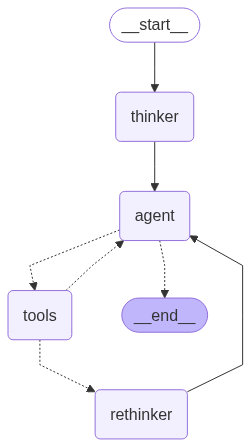

In [ ]:
from IPython.display import Image, display
from langchain_core.language_models.fake import FakeListLLM

clauses_input = [[-1, 2], [1, -2]]
solver = ReactSatSolver(chat_model=chat_model, clauses=clauses_input)
graph_image = solver.get_graph_image()
display(Image(graph_image))

In [ ]:
from NP_problems import verify_3sat_solution, generate_3sat_instance

# clauses_input = [[-1, 2, -3], [-1, -2, 3], [-1, 2, 3], [-1, -2, -3], [-4, 3, 1], [-4, -3, -1]]
clauses_input, known_solution = generate_3sat_instance(num_vars=8, num_clauses=50, use_random_weights=False)
solver = ReactSatSolver(chat_model, clauses_input)
solution, execution_time = solver.solve(verbose=True)
print(f"Final Assignment: {solution}")

############################ Solving 3-SAT Problem #############################
Clauses: [[-8, 1, -3], [3, 5, -8], [-6, 2, -3], [5, 7, -8], [-1, -3, -7], [8, 4, -7], [1, 4, 6], [4, -2, 8], [8, 5, -3], [-3, -7, 2], [-3, 1, -8], [-2, -4, -3], [3, 6, 2], [5, 2, 7], [-3, -6, -8], [-7, -5, 2], [-5, 3, 6], [7, 2, 1], [-8, -4, 3], [5, 3, 2], [-1, 3, 2], [5, 6, -2], [-5, 8, -2], [-7, 2, 1], [-5, -3, 7], [4, 6, 8], [-3, 1, 5], [-8, 6, 3], [6, 7, 8], [-3, 6, -7], [-5, 4, -2], [8, -5, -3], [7, -8, 1], [-1, 4, 6], [-3, -4, 2], [3, 2, -8], [-7, -1, -2], [-5, -4, 3], [-1, 2, 5], [-2, 1, 7], [-5, -7, 8], [3, -8, 5], [3, -1, 6], [-5, -7, -3], [8, 7, -3], [2, -7, 5], [7, -2, 3], [6, 2, 7], [7, -3, 6], [-8, -6, 7]]

==================================== Step 1 ====================================
================================ Human Message =================================

Please find a satisfying assignment for the following clauses: [[-8, 1, -3], [3, 5, -8], [-6, 2, -3], [5, 7, -8], [-1, -3, -7], 

  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 32
}
].


=================================== Step 25 ====================================
================================== Ai Message ==================================

Reasoning: I am in the Standard Backtracking phase. The previous assignment `{"1": true, "2": true, "3": true, "4": true, "5": true, "6": true, "7": true}` resulted in an "Incomplete" status with `v8` as the only unassigned variable. According to the rules, I should make a strategic guess by setting the first unassigned variable (`v8`) to `True`. I will now check this complete assignment.
Tool Calls:
  check_assignment (4462c07b-ca38-46e9-bd65-f2b338fe2b49)
 Call ID: 4462c07b-ca38-46e9-bd65-f2b338fe2b49
  Args:
    assignment_str: {"1": true, "2": true, "3": true, "4": true, "5": true, "6": true, "7": true, "8": true}
=================================== Step 26 ====================================
================================= Tool Message =================================
Name: check_assignment

{"status": "Contradiction

ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 29
}
]